<a href="https://colab.research.google.com/github/WittyTheMighty/ML-kaggle/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Final Kaggle competition ML

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [29]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import torch as torch
import torchvision as  tv
import torch.nn as nn
import torchvision.transforms as transforms
import os
import pandas as pd
import pickle as pkl
from matplotlib import cm
from PIL import Image
import torch.optim as optim
import torch.nn as nn 
import torch.nn.functional as F 
import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import csv
import scipy as sp
import copy


11887


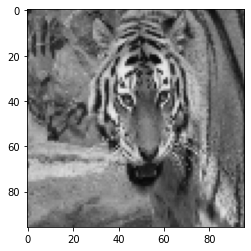

In [70]:
#PATH = './drive/MyDrive/ML-Kaggle/'
# PATH = "/content/drive/MyDrive/ML-Kaggle/"
PATH = '../data/'

x_train_scalar = np.array(pkl.load(open(PATH+'x_train.pkl', 'rb')))
y_train = np.array(pkl.load(open(PATH+'y_train.pkl', 'rb')))
x_test =  np.array(pkl.load(open(PATH+'x_test.pkl', 'rb')))

print(x_train_scalar.shape[0])

x_train = x_train_scalar

plt.imshow(x_train[0] , cmap='gray', vmin=0, vmax=255)

#x_train = []

#for image in x_train_scalar:
#    imge_out = Image.fromarray(image.astype('uint8'))
#    img_as_img = imge_out.convert("RGB")
#    x_train.append(np.array(img_as_img))
    
#x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))

#plt.imshow(np.transpose(x_train[0], (1, 2 , 0)))

In [48]:
labels = np.unique(y_train)
labels = dict(zip(labels, range(len(labels))))
labels

{'big_cats': 0,
 'butterfly': 1,
 'cat': 2,
 'chicken': 3,
 'cow': 4,
 'dog': 5,
 'elephant': 6,
 'goat': 7,
 'horse': 8,
 'spider': 9,
 'squirrel': 10}

In [49]:
x_train.shape

(11887, 96, 96)

---

## Hyperparameters

In [154]:
batch_size = 64
num_epochs = 20

#pooling
pooling_filter_size = 2
pooling_stride = 2

#k-fold-validation
k_folds = 5


---

## Preprocessing

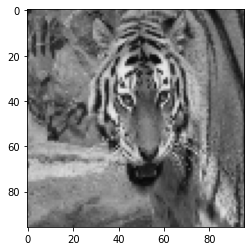

In [15]:
#First preprocessing step 

#Utilitary function for geometric preprocessing
# def flip_verticaly(X):
#     flipped_image = copy.deepcopy(rotate90(X))
#     for idx,channel in enumerate(flipped_image):
#         flipped_image[idx]= np.fliplr(channel)

#     return rotate(flipped_image, 270)


def flip_horizontaly(X):
    flipped_image = copy.deepcopy(X)
    for idx,channel in enumerate(flipped_image):
        flipped_image[idx]= np.fliplr(channel)

    return flipped_image

def rotate90(X):
    rot90_img = copy.deepcopy(X)
    for idx,channel in enumerate(rot90_img):
        rot90_img[idx]= np.rot90(channel)
    return rot90_img

def rotate(degree,X):
    rot_img = copy.deepcopy(X)
    for idx,channel in enumerate(rot_img):
        rot_img[idx]= sp.ndimage.rotate(channel, degree, reshape=False)
    return rot_img

#An adaptation from:
# https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions
def clipped_zoom(img, zoom_factor):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = sp.ndimage.zoom(img, zoom_tuple)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = sp.ndimage.zoom(img[top:top+zh, left:left+zw], zoom_tuple)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

def blur(X,blur_factor):
    blur_img = copy.deepcopy(X)
    for idx,channel in enumerate(blur_img):
        blur_img[idx]= sp.ndimage.gaussian_filter(channel, sigma=blur_factor)
    return blur_img

plt.imshow(np.transpose(x_train[0], (1,2,0)))

In [16]:
zoom_factors = [0.9, 1.1, 1.4, 1.6]
x_train_zoomed_vertical = np.array([clipped_zoom(x,np.random.choice(zoom_factors)) for x in x_train])
x_train_zoomed_horizontal = np.array([rotate(270,clipped_zoom(rotate90(x),np.random.choice(zoom_factors))) for x in x_train])

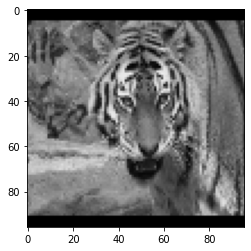

In [17]:
plt.imshow(np.transpose(x_train_zoomed_vertical[0],(1,2,0)))

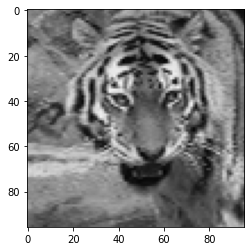

In [18]:
plt.imshow(np.transpose(x_train_zoomed_horizontal[0],(1,2,0)))

In [19]:
x_train_rotated = np.array([rotate(round(np.random.random()*360), x) for x in x_train])

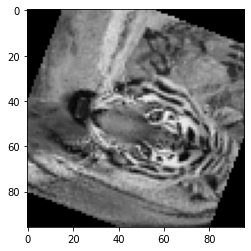

In [20]:
plt.imshow(np.transpose(x_train_rotated[0],(1,2,0)))

In [21]:
x_train_flipped_horizontally = np.array([flip_horizontaly(x) for x in x_train])

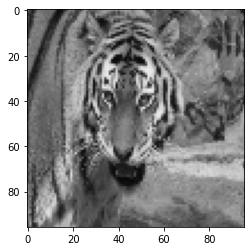

In [22]:
plt.imshow(np.transpose(x_train_flipped_horizontally[0],(1,2,0)))

In [23]:
augmented_x_train = np.concatenate([x_train, x_train_zoomed_horizontal, x_train_zoomed_vertical, x_train_rotated, x_train_flipped_horizontally], axis=0)
augmented_x_train.shape

(59435, 3, 96, 96)

In [24]:
augmented_y_train = np.concatenate([y_train]*5)
augmented_y_train.shape

(59435,)

In [25]:
# SAVE AUGMENTED TRAINING SET
pkl.dump(augmented_x_train,open(PATH+'x_train_aug.pkl', 'wb'))
pkl.dump(augmented_y_train,open(PATH+'y_train_aug.pkl', 'wb'))

In [26]:
# LOAD AUGMENTED TRAINING SET
x_train = pkl.load(open(PATH+'x_train_aug.pkl', 'rb'))
y_train = pkl.load(open(PATH+'y_train_aug.pkl', 'rb'))

---
## Model

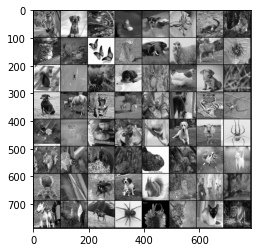

In [73]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda')
#device = torch.device("cpu")

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.utils as vutils

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)
    

#y_train = np.array([labels[y] for y in y_train])
#x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0, random_state=4)

# idx = np.random.choice(np.arange(len(x_train)), 10000, replace=False)
# x_sample = x_train[idx]
# y_sample = y_train[idx]

x_train_tensor = torch.tensor(x_train, dtype=float)[:, None, :, :]
y_train_tensor = torch.tensor(np.array([labels[y] for y in y_train]), dtype=float)

trans = transforms.Compose(
    [transforms.Normalize((0.5), (0.5))]
)
train_dataset = CustomTensorDataset(tensors=(x_train_tensor, y_train_tensor), transform=trans)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=False)

#x_train_tensor.shape
real_batch = next(iter(train_dataloader))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [77]:
conv1 = nn.Conv2d(1,3,5)
pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
conv2 = nn.Conv2d(3,6,5)
images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)
print("")

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)
print("")

x = pool(x)
print("POOL2")
print(x.shape)
print("")

images
torch.Size([64, 1, 96, 96])

CONV1
torch.Size([64, 3, 92, 92])

POOL1
torch.Size([64, 3, 46, 46])

CONV2
torch.Size([64, 6, 42, 42])

POOL2
torch.Size([64, 6, 21, 21])



In [81]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 5)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(3,6,5) 
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(6*21*21, 240) 
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6*21*21)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net().to(device)

In [136]:
conv1 = nn.Conv2d(1,3,3)
pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
conv2 = nn.Conv2d(3,6,5)
conv3 = nn.Conv2d(6,16,7)

images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)

x = pool(x)
print("POOL2")
print(x.shape)
print("")

x = conv3(x)
print("CONV3")
print(x.shape)

x = pool(x)
print("POOL3")
print(x.shape)
print("")


images
torch.Size([64, 1, 96, 96])

CONV1
torch.Size([64, 3, 94, 94])
POOL1
torch.Size([64, 3, 47, 47])

CONV2
torch.Size([64, 6, 43, 43])
POOL2
torch.Size([64, 6, 21, 21])

CONV3
torch.Size([64, 16, 15, 15])
POOL3
torch.Size([64, 16, 7, 7])



In [138]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(1,3,3)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(3,6,5)
        self.conv3 = nn.Conv2d(6,16,7)
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(16*7*7, 240) 
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net().to(device)

In [151]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(1,3,3)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(3,6,5)
        self.conv3 = nn.Conv2d(6,16,7)
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(16*7*7, 120) 
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [118]:
conv1 = nn.Conv2d(1,3,3)
pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
conv2 = nn.Conv2d(3,6,3)
conv3 = nn.Conv2d(6,16,5)
conv4 = nn.Conv2d(16,26,7)

images = real_batch[0].float()
print("images")
print(images.shape)
print("")

x = conv1(images)
print("CONV1")
print(x.shape)

x = pool(x)
print("POOL1")
print(x.shape)
print("")

x = conv2(x)
print("CONV2")
print(x.shape)

x = pool(x)
print("POOL2")
print(x.shape)
print("")

x = conv3(x)
print("CONV3")
print(x.shape)

x = pool(x)
print("POOL3")
print(x.shape)
print("")

x = conv4(x)
print("CONV3")
print(x.shape)

images
torch.Size([64, 1, 96, 96])

CONV1
torch.Size([64, 3, 94, 94])
POOL1
torch.Size([64, 3, 47, 47])

CONV2
torch.Size([64, 6, 45, 45])
POOL2
torch.Size([64, 6, 22, 22])

CONV3
torch.Size([64, 16, 18, 18])
POOL3
torch.Size([64, 16, 9, 9])

CONV3
torch.Size([64, 26, 3, 3])


In [137]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(1,3,3)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(pooling_filter_size, pooling_stride)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(3,6,3)
        self.conv3 = nn.Conv2d(6,16,5)
        self.conv4 = nn.Conv2d(16,26,7)
        # 5*5 comes from the dimension of the last convnet layer
        self.fc1 = nn.Linear(26*3*3, 240) 
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 11)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 26*3*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer 
        return x

net = Net().to(device)

In [152]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [155]:
# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

running_loss = 0 
printfreq = 25

network = Net().to(device)
network.apply(reset_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=batch_size, sampler=test_subsampler)
    
    network = Net().to(device)
    network.apply(reset_weights)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)
    

    for epoch in range(num_epochs):
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()
            optimizer.zero_grad()
            outputs = network(inputs)  # forward pass 
            outputs = outputs.float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            current_loss += loss.item()
            if i % printfreq == printfreq - 1 :
                print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / printfreq))
                current_loss = 0.0
         # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)
    
    # Evaluationfor this fold
    correct, total = 0, 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data
        
        inputs = inputs.float().to(device)
        targets = targets.to(device)

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

Reset trainable parameters of layer = Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=784, out_features=120, bias=True)
Reset trainable parameters of layer = Linear(in_features=120, out_features=60, bias=True)
Reset trainable parameters of layer = Linear(in_features=60, out_features=11, bias=True)
FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=784, out_features=120, bias=True)
Reset trainable parameters of layer = Linear(in_features=120, out_features=60, bi

Loss after mini-batch    50: 0.885
Loss after mini-batch    75: 0.952
Loss after mini-batch   100: 0.929
Loss after mini-batch   125: 0.969
Starting epoch 15
Loss after mini-batch    25: 0.716
Loss after mini-batch    50: 0.749
Loss after mini-batch    75: 0.847
Loss after mini-batch   100: 0.820
Loss after mini-batch   125: 0.837
Starting epoch 16
Loss after mini-batch    25: 0.689
Loss after mini-batch    50: 0.721
Loss after mini-batch    75: 0.764
Loss after mini-batch   100: 0.808
Loss after mini-batch   125: 0.851
Starting epoch 17
Loss after mini-batch    25: 0.604
Loss after mini-batch    50: 0.564
Loss after mini-batch    75: 0.634
Loss after mini-batch   100: 0.642
Loss after mini-batch   125: 0.747
Starting epoch 18
Loss after mini-batch    25: 0.580
Loss after mini-batch    50: 0.521
Loss after mini-batch    75: 0.562
Loss after mini-batch   100: 0.596
Loss after mini-batch   125: 0.768
Starting epoch 19
Loss after mini-batch    25: 0.498
Loss after mini-batch    50: 0.468


Loss after mini-batch   100: 1.421
Loss after mini-batch   125: 1.420
Starting epoch 10
Loss after mini-batch    25: 1.326
Loss after mini-batch    50: 1.339
Loss after mini-batch    75: 1.292
Loss after mini-batch   100: 1.348
Loss after mini-batch   125: 1.392
Starting epoch 11
Loss after mini-batch    25: 1.193
Loss after mini-batch    50: 1.232
Loss after mini-batch    75: 1.293
Loss after mini-batch   100: 1.248
Loss after mini-batch   125: 1.254
Starting epoch 12
Loss after mini-batch    25: 1.157
Loss after mini-batch    50: 1.143
Loss after mini-batch    75: 1.173
Loss after mini-batch   100: 1.254
Loss after mini-batch   125: 1.222
Starting epoch 13
Loss after mini-batch    25: 1.004
Loss after mini-batch    50: 1.028
Loss after mini-batch    75: 1.055
Loss after mini-batch   100: 1.130
Loss after mini-batch   125: 1.097
Starting epoch 14
Loss after mini-batch    25: 0.943
Loss after mini-batch    50: 0.924
Loss after mini-batch    75: 0.983
Loss after mini-batch   100: 0.947


In [18]:
network = Net()
network.load_state_dict(torch.load('./model-fold-4.pth'))
network.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 26, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=1274, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=60, bias=True)
  (fc4): Linear(in_features=60, out_features=11, bias=True)
)

In [ ]:
x_test_tensor = torch.tensor(x_test, dtype=float)
y_test_tensor = torch.tensor(y_test, dtype=float)

test_dataset = CustomTensorDataset(tensors=(x_test_tensor, y_test_tensor), transform=trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [ ]:
numberOfBatches = 0
totalAccuracy = 0

for i, data in enumerate(test_dataloader):
    numberOfBatches += 1
    inputs, labels = data
    
    outputs = network(inputs.float())
    
    print(outputs.shape)

    preds = outputs.argmax(dim=1).cpu()
    
    print(preds.shape)
    print(preds)
    print(labels.shape)
    print(labels)
    print("")

    totalAccuracy += accuracy_score(labels.cpu(), preds.cpu())

print(totalAccuracy / numberOfBatches)

In [9]:
def make_submission(x_test, network):
    header = ["Id", "class"]
    id_value = 0
    
    classifications =[]
    for image in tqdm.tqdm(x_test):
        image = torch.reshape(image, (1, 3, 96, 96))
        classifications.append([id_value, network(image.float()).argmax(dim=1)[0].item()])
        id_value += 1
    
    y = PATH+"./submission.csv"
    with open(y, 'w', newline='') as work:
        z = csv.writer(work)
        z.writerow(header)
        z.writerows(classifications)

In [10]:
x_test_scalar =  np.array(pkl.load(open(PATH+'x_test.pkl', 'rb')))

x_test = []

for image in x_test_scalar:
    imge_out = Image.fromarray(image.astype('uint8'))
    img_as_img = imge_out.convert("RGB")
    x_test.append(np.array(img_as_img))
    

x_test = np.transpose(np.array(x_test), (0, 3, 1, 2))

x_test = torch.tensor(x_test, dtype=float)

network = Net()
network.load_state_dict(torch.load('./model-fold-4.pth'))
network.eval()

make_submission(x_test, network)

100%|██████████| 17831/17831 [00:35<00:00, 502.66it/s]
